# Autoreload and logging config

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment2RRBSDataSource').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

# Download data files

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file

data_dir = 'data/assignment2'
#meta_csv_filepath = os.path.join(data_dir, 'MetaPolished.csv')
#features_csv_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv')
#features_zip_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip')

meta_csv_filepath = os.path.join(data_dir, 'MetaPolished.csv')
features_csv_filepath = os.path.join(data_dir, 'FTGenForGenomicCov.py-cov5.csv')
features_zip_filepath = os.path.join(data_dir, 'FTGenForGenomicCov.py-cov5.csv.zip')


# download meta file
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/MetaPolished.csv',
              out_filepath=meta_csv_filepath)

# download features file if does not exists
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip',
              out_filepath=features_csv_filepath, 
              intermediate_archive_filepath=features_zip_filepath,
              archive_format='zip')


DEBUG:download_file:file data/assignment2/MetaPolished.csv already exists; do not download again
DEBUG:download_file:file data/assignment2/FTGenForGenomicCov.py-cov5.csv already exists; do not download again


CPU times: user 2.19 s, sys: 2.83 s, total: 5.02 s
Wall time: 3.25 s


# Load data

In [ ]:
%%time

import os
from epigenetic_clock_assignment import Assignment2RRBSDataSource

data_source = Assignment2RRBSDataSource(
    meta_csv_filepath=meta_csv_filepath,
    features_csv_filepath=features_csv_filepath,
    features_pickle_cache_filepath=os.path.join(data_dir, 'features_cache.pickle'))

X, y, meta_df = data_source.load()

print(meta_df)

DEBUG:Assignment2RRBSDataSource:load
DEBUG:Assignment2RRBSDataSource:loading features from cache file "data/assignment2/features_cache.pickle"...
DEBUG:Assignment2RRBSDataSource:loaded; shape=(182, 8722093)
DEBUG:Assignment2RRBSDataSource:joining based on ID
DEBUG:Assignment2RRBSDataSource:joined; shape=(182, 8722096)
DEBUG:Assignment2RRBSDataSource:creating y
DEBUG:Assignment2RRBSDataSource:creating X


# Hyperparameter optimization (ElasticNet $\lambda, \alpha$)

In [4]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=1,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test, meta_train, meta_test = clock_trainer.train_test_split(X, y, meta_df,
                                                                  test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(
    X_train=X_train, 
    y_train=y_train, 
    alpha_count= 2 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.5 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.5...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


CPU times: user 5min 41s, sys: 3min 53s, total: 9min 35s
Wall time: 8min 48s


# Plot hyperparameter optimization result

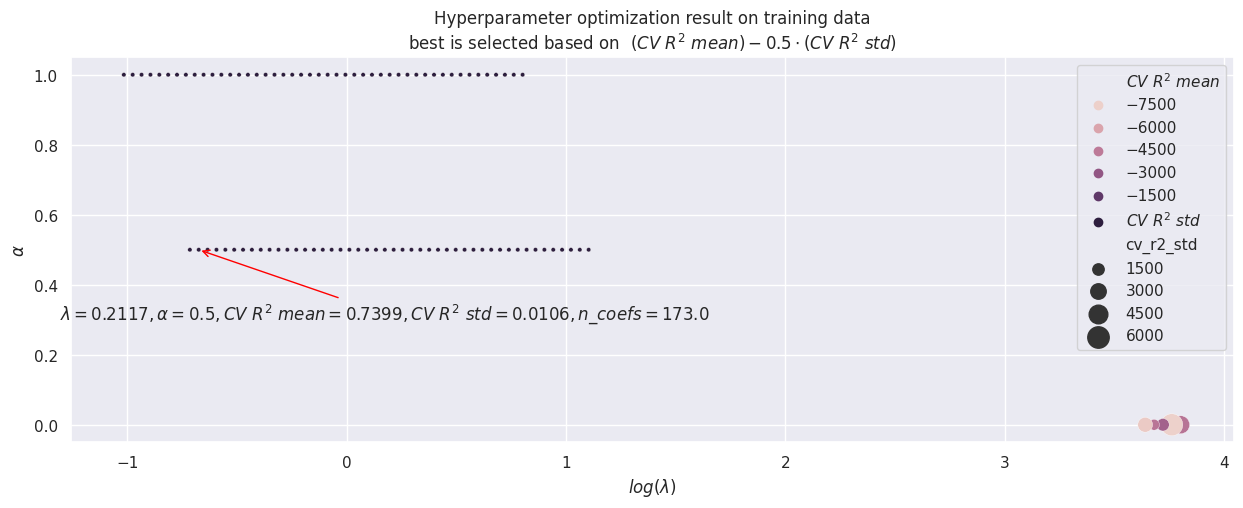

In [5]:
clock_trainer.plot_hyperparameter_optimization_result(
    hyperparameter_result=hyperparameter_result, 
    hyperparameter_stats=hyperparameter_stats)

# Predict on test data using the best model

In [6]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_test_pred = best_model.predict(X = X_test, lamb=best_lambda)


# Plot linear regression result on test data

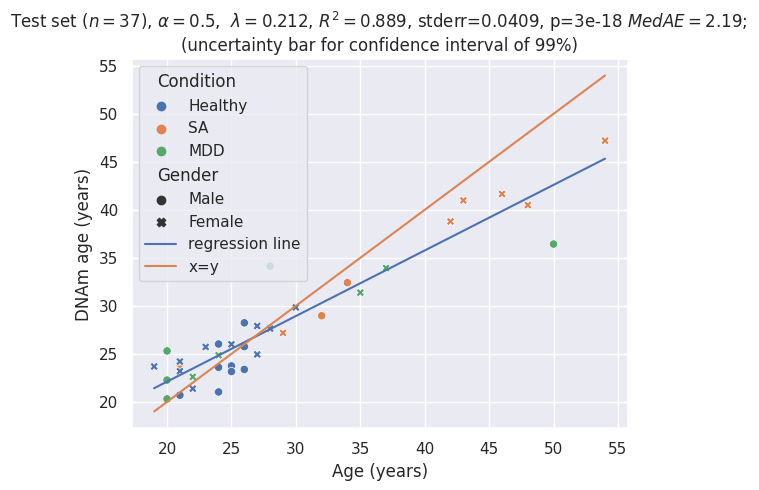

Statistics(r2=0.8885296177291722, slope=0.6831130028293093, intercept=8.442925215962042, p_value=2.9943218461871238e-18, standard_error=0.04089802355066031, medae=2.190172253783146, delta_age=array([ -2.9694408 ,  -3.20543127,  -4.34431591,   2.71899267,
         2.57857015,  -0.15888244,  -0.40038778,   6.14028085,
         0.60274385,   0.99785746,  -3.03331097,   5.30456573,
         0.85968032,  -3.06338109,   2.02422196,   2.23024556,
        -1.81485719,  -7.50091615,  -2.62443716,   0.90315417,
         0.30809355,  -0.30401208,  -1.25676363,   4.68407108,
        -6.78778791,   2.19017225,  -2.05660767,  -1.8428009 ,
       -13.56462434,  -0.24516777,  -3.62235188,  -1.58078362,
        -2.01119381,   3.20084203,   2.26954333,  -0.62411759,
        -0.36543   ]), age_acceleration=array([-3.80707809,  1.6608974 ,  1.78956075,  1.56446839,  0.79027187,
        0.90480226, -1.23802507,  6.57019156, -0.86866743,  0.47710718,
       -1.33585228,  3.19938046,  0.02204303,  0.21851259

In [7]:
test_stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_test_pred)
clock_trainer.plot_linear_regression_result(
    y_true=y_test, 
    y_pred=y_test_pred, 
    stats=test_stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    title_prefix='Test set',
    hue=meta_test['Condition'],
    style=meta_test['Gender'])

print(test_stats)


In [8]:
# predict
y_pred = best_model.predict(X = X, lamb=best_lambda)


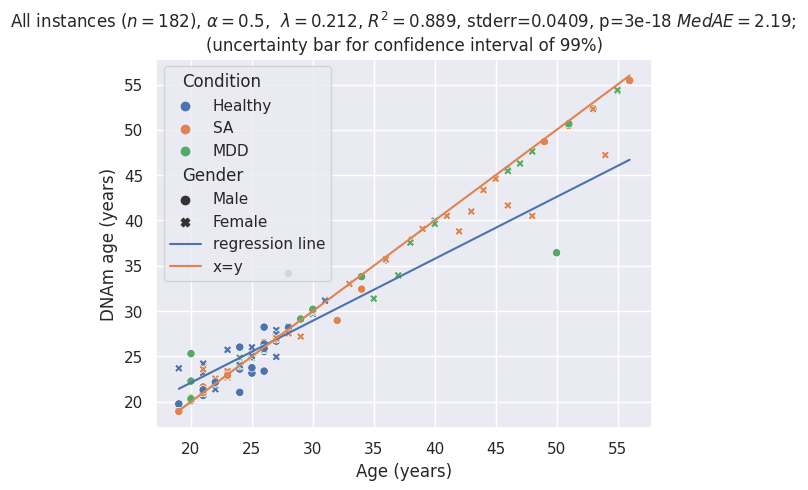

In [9]:
stats = clock_trainer.calculate_statistics(y_true=y, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(
    y_true=y, 
    y_pred=y_pred, 
    stats=test_stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    title_prefix='All instances',
    hue=meta_df['Condition'],
    style=meta_df['Gender'])



            Gender Condition  age_acceleration  delta_age   age   pred_age
acc                                                                       
SRR9190430    Male   Healthy         -0.037481   0.223950  24.0  24.223950
SRR9190431    Male   Healthy          0.042935  -0.220683  30.0  29.779317
SRR9190432    Male   Healthy          0.124624  -0.138994  30.0  29.861006
SRR9190433  Female   Healthy         -0.003216   0.345724  23.0  23.345724
SRR9190434    Male   Healthy         -0.318518  -0.319611  27.0  26.680389
...            ...       ...               ...        ...   ...        ...
SRR9190788    Male   Healthy         -0.223971   0.299985  21.0  21.299985
SRR9190789    Male   Healthy         -0.272868   0.163580  22.0  22.163580
SRR9190790    Male   Healthy         -0.207942  -0.121527  26.0  25.878473
SRR9190791  Female   Healthy         -0.120955   0.052968  25.0  25.052968
SRR9190792  Female   Healthy         -0.219697   0.041735  24.0  24.041735

[182 rows x 6 columns]
 

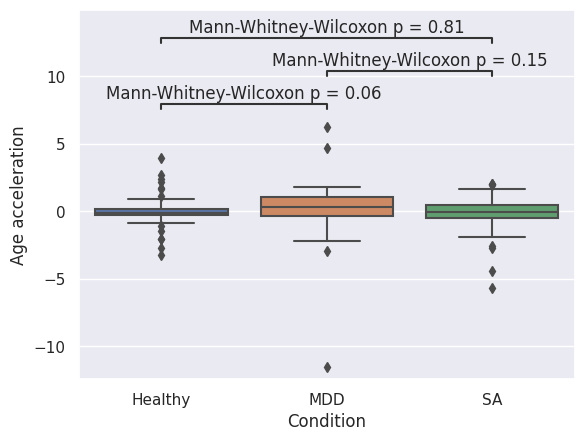

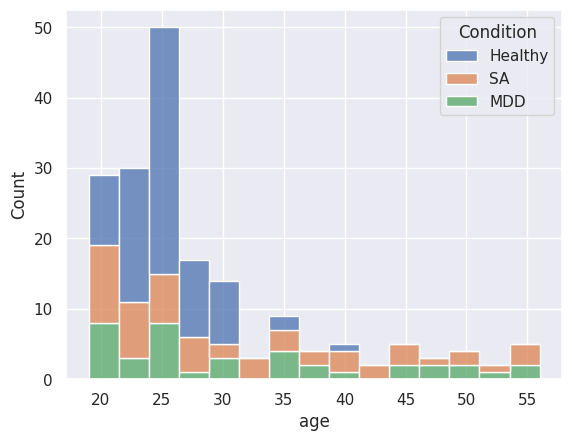

In [10]:
import seaborn as sns
import scipy.stats as scipystats
import pandas as pd
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

order = ['Healthy', 'MDD', 'SA']
fig, ax = plt.subplots()

plotting_parameters = {
    'x': meta_df['Condition'],
    'y': stats.age_acceleration,
    'order': order
}

sns.boxplot(ax=ax, **plotting_parameters)

meta_with_stats_df = meta_df.copy()
meta_with_stats_df['age_acceleration'] = stats.age_acceleration
meta_with_stats_df['delta_age'] = stats.delta_age
meta_with_stats_df['age'] = y
meta_with_stats_df['pred_age'] = y_pred
print(meta_with_stats_df)

print(meta_df.groupby('Condition').count())

def check_normality(x: pd.Series):
    res = scipystats.shapiro(x) 
    return res.pvalue

print(meta_with_stats_df['age_acceleration'].agg(is_normal_p_value=lambda x: check_normality(x)))

print(meta_with_stats_df.groupby('Condition')['age_acceleration'].agg(is_normal_p_value=lambda x: check_normality(x)))
# age acceleration is not normally distributed

print('age is normal', meta_with_stats_df.groupby('Condition')['age'].agg(is_normal_p_value=lambda x: check_normality(x)))
print('age is normal in whole dataset', meta_with_stats_df['age'].agg(is_normal_p_value=lambda x: check_normality(x)))



# non normally distributed, we will use Mann-Whitney-Wilcoxon

condition_groupby = meta_with_stats_df.groupby('Condition')
healthy_group = condition_groupby.get_group('Healthy')
mdd_group = condition_groupby.get_group('MDD')
sa_group = condition_groupby.get_group('SA')

healthy_vs_mdd = scipystats.mannwhitneyu(healthy_group['age_acceleration'], mdd_group['age_acceleration'])
healthy_vs_sa = scipystats.mannwhitneyu(healthy_group['age_acceleration'], sa_group['age_acceleration'])
mdd_vs_sa = scipystats.mannwhitneyu(mdd_group['age_acceleration'], sa_group['age_acceleration'])
print('healthy_vs_mdd', healthy_vs_mdd)
print('healthy_vs_sa', healthy_vs_sa)
print('mdd_vs_sa', mdd_vs_sa)
# TODO: https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

pairs = [('Healthy', 'MDD'), ('Healthy', 'SA'), ('MDD', 'SA')]

annotator = Annotator(ax, pairs, **plotting_parameters)
#annotator.set_custom_annotations(['1', '2', '3'])
annotator.configure(text_format="simple", test_short_name='Mann-Whitney-Wilcoxon')
annotator.set_pvalues([healthy_vs_mdd.pvalue, healthy_vs_sa.pvalue, mdd_vs_sa.pvalue])
annotator.annotate()
ax.set_ylabel('Age acceleration')
plt.show()

sns.histplot(data=meta_with_stats_df, x='age', hue='Condition', multiple='stack')
plt.show()


In [11]:
pd.__version__

'1.5.3'

healthy_mdd_sa_merged


,age,delta_age,age_acceleration,Condition
0,20.0,0.245891,-0.365574,Healthy
1,20.0,0.379438,-0.232027,Healthy
2,21.0,0.240544,-0.283412,Healthy
3,21.0,3.200842,2.676886,Healthy
4,21.0,2.190172,1.666216,Healthy
5,21.0,-0.304012,-0.827968,Healthy
6,21.0,0.272746,-0.251210,Healthy
7,21.0,0.299985,-0.223971,Healthy
8,22.0,-0.150804,-0.587252,Healthy
9,22.0,0.259030,-0.177418,Healthy


healthy_vs_mdd MannwhitneyuResult(statistic=2564.0, pvalue=0.1478434030789009)
healthy_vs_sa MannwhitneyuResult(statistic=2770.0, pvalue=0.48274920458777226)
mdd_vs_sa MannwhitneyuResult(statistic=3213.0, pvalue=0.36899329440679884)
Healthy vs. MDD: Custom statistical test, P_val:1.478e-01
MDD vs. SA: Custom statistical test, P_val:3.690e-01
Healthy vs. SA: Custom statistical test, P_val:4.827e-01


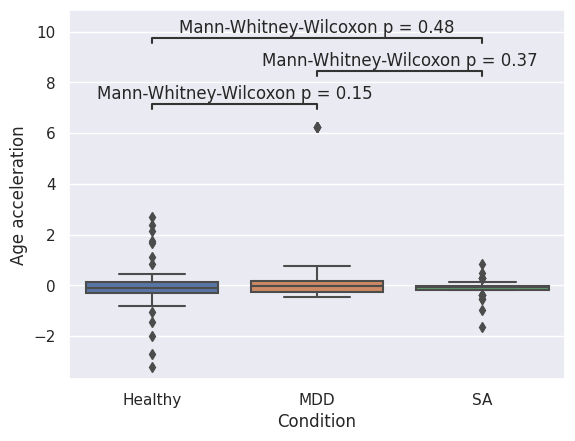

In [12]:
from IPython.display import display
# match

#print(healthy_group, type(healthy_group))

#healthy_group.sort_values('age')

healthy_mdd_merged = pd.merge_asof(healthy_group.rename(columns={'age':'age_healthy'}).sort_values('age_healthy'), mdd_group.rename(columns={'age':'age_mdd'}).sort_values('age_mdd'), 
                                   right_on='age_mdd', left_on='age_healthy',
                                   suffixes=('_healthy', '_mdd'), direction='nearest', tolerance=0)

healthy_mdd_merged = healthy_mdd_merged.dropna()
#alma = pd.DataFrame()
#alma['age'] = healthy_mdd_merged['age']
#alma['age_acceleration_healthy'] = healthy_mdd_merged['age_acceleration_healthy']
#healthy_mdd_merged = healthy_mdd_merged.reset_index(drop=True)


healthy_mdd_sa_merged = pd.merge_asof(left=healthy_mdd_merged.sort_values('age_healthy'), right=sa_group.rename(columns={'age':'age_sa', 'delta_age':'delta_age_sa', 'age_acceleration': 'age_acceleration_sa'}) .sort_values('age_sa'), 
                                   right_on='age_sa', left_on='age_healthy',
                                    direction='nearest', tolerance=0)

healthy_mdd_sa_merged = healthy_mdd_sa_merged[['age_healthy', 'age_mdd', 'age_sa',
                                               'delta_age_healthy', 'delta_age_mdd', 'delta_age_sa',
                                              'age_acceleration_healthy', 'age_acceleration_mdd', 'age_acceleration_sa']]
healthy_mdd_sa_merged = healthy_mdd_sa_merged.dropna()
#print('healthy_mdd_merged')
#with pd.option_context('display.max_rows', None, ):
#    display(healthy_mdd_merged)

controlled_dfs = []

class_names = ['Healthy', 'MDD', 'SA']
for i, cls in enumerate(['healthy', 'mdd', 'sa']):
    controlled_df = healthy_mdd_sa_merged[[f'age_{cls}', f'delta_age_{cls}', f'age_acceleration_{cls}']]
    controlled_df = controlled_df.assign(Condition=class_names[i])
    controlled_df = controlled_df.rename(columns={f'age_{cls}': 'age', f'delta_age_{cls}': 'delta_age', f'age_acceleration_{cls}': 'age_acceleration'})
    controlled_dfs.append(controlled_df)
    
merged_controlled_dfs = pd.concat(controlled_dfs)

#controlled_healthy_df = healthy_mdd_sa_merged[['age_healthy', 'delta_age_healthy', 'age_acceleration_healthy']]
#controlled_healthy_df = controlled_healthy_df.assign(Condition='Healthy')

#controlled_mdd_df = healthy_mdd_sa_merged[['age_mdd', 'delta_age_mdd', 'age_acceleration_mdd']]
#controlled_mdd_df = controlled_mdd_df.assign(Condition= 'MDD')

#controlled_sa_df = healthy_mdd_sa_merged[['age_sa', 'delta_age_sa', 'age_acceleration_sa']]
#controlled_sa_df = controlled_sa_df.assign(Condition= 'SA')


print('healthy_mdd_sa_merged')
with pd.option_context('display.max_rows', None, ):
    display(merged_controlled_dfs)

#print(type(healthy_mdd_merged))

order = ['Healthy', 'MDD', 'SA']
fig, ax = plt.subplots()

plotting_parameters = {
    'x': merged_controlled_dfs['Condition'],
    'y': merged_controlled_dfs['age_acceleration'],
    'order': order
}

sns.boxplot(ax=ax, **plotting_parameters)

condition_groupby = merged_controlled_dfs.groupby('Condition')
healthy_group = condition_groupby.get_group('Healthy')
mdd_group = condition_groupby.get_group('MDD')
sa_group = condition_groupby.get_group('SA')

healthy_vs_mdd = scipystats.mannwhitneyu(healthy_group['age_acceleration'], mdd_group['age_acceleration'])
healthy_vs_sa = scipystats.mannwhitneyu(healthy_group['age_acceleration'], sa_group['age_acceleration'])
mdd_vs_sa = scipystats.mannwhitneyu(mdd_group['age_acceleration'], sa_group['age_acceleration'])
print('healthy_vs_mdd', healthy_vs_mdd)
print('healthy_vs_sa', healthy_vs_sa)
print('mdd_vs_sa', mdd_vs_sa)


annotator = Annotator(ax, pairs, **plotting_parameters)
#annotator.set_custom_annotations(['1', '2', '3'])
annotator.configure(text_format="simple", test_short_name='Mann-Whitney-Wilcoxon')
annotator.set_pvalues([healthy_vs_mdd.pvalue, healthy_vs_sa.pvalue, mdd_vs_sa.pvalue])
annotator.annotate()
ax.set_ylabel('Age acceleration')
plt.show()


#healthy_group = condition_groupby.get_group('Healthy')
#mdd_group = condition_groupby.get_group('MDD')
#sa_group = condition_groupby.get_group('SA')

